In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from matplotlib.lines import Line2D
import ast
import loss_functions
from statannot import add_stat_annotation
from scipy import interpolate
import os
sns.set_style(style='white')

In [2]:
exp_measures = pd.read_csv("data/measures.csv")

condition_map = utils.get_nudge_condition_map()
conditions = condition_map.values()
exp_measures["a_values"] = exp_measures.a_values.apply(ast.literal_eval).apply(tuple)
exp_measures["condition"] = pd.Categorical(exp_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

In [31]:
def plot_var_by_condition(exp_measures, model_measures, var, model_label, include_model=True, include_legend=False, subfigure_label=""):
    tta_conditions = [4.5, 5.5]
    d_0 = 80
    markers=["o", "s"]
    colors = ["C0", "C1"]

    fig, ax = plt.subplots(1, 1, figsize=(3,3), sharex=True, sharey=True)
    for tta, color, marker in zip(tta_conditions, colors, markers):
        exp_measures_by_condition = exp_measures[(exp_measures.tta_0 == tta)]

        if include_model:
            model_measures_by_condition = model_measures[(model_measures.tta_0==tta) & (model_measures.d_0==d_0)].sort_values("condition")

        if (var == "is_go_decision") | (var == "is_negative_rating"):
            psf_ci = utils.get_psf_ci(exp_measures_by_condition, var=var)
            ax.plot(psf_ci.condition, psf_ci.p, ls="", marker=marker, ms=9, color=color, zorder=10)
            ax.vlines(x=psf_ci.condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)

            if include_model:
                ax.plot(model_measures_by_condition.condition, model_measures_by_condition.is_gap_accepted, color=color, label=tta)
        else:
            exp_measures_by_condition = (exp_measures_by_condition[(exp_measures_by_condition.is_go_decision)]
                                         if var == "RT_go"
                                         else exp_measures_by_condition[~(exp_measures_by_condition.is_go_decision)])

            measures_mean_sem = utils.get_mean_sem(exp_measures_by_condition, var="RT",
                                                   groupby_var="condition", n_cutoff=10).reindex(conditions)
            ax.errorbar(measures_mean_sem.index, measures_mean_sem["mean"], yerr=measures_mean_sem["sem"], ls="", marker=marker, ms=9, color=color)
            if include_model:
                ax.plot(model_measures_by_condition.condition, model_measures_by_condition[var], color=color, label=tta)

    if var=="is_go_decision":
        ylabel = "p(go)"
        ax.set_ylim((0, 1))
    elif var=="is_negative_rating":
        ylabel = "p(negative rating)"
        ax.set_ylim((0, 0.2))
    elif var=="RT_go":
        ylabel = "go RT"
        ax.set_ylim((0.2, 2.2))
    elif var=="RT_stay":
        ylabel = "stay RT"
        ax.set_ylim((0.2, 2.2))

    ax.set_ylabel(ylabel, fontsize=12)

    fig.text(0.0, 1.0, subfigure_label, fontsize=12)

    sns.despine(offset=5, trim=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.tight_layout()

    if include_legend:
        legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0,
                                   label="Data, TTA=%.1fs" % (tta_condition))
                            for tta_condition, color, marker in zip(tta_conditions, colors, markers)]
                           + ([Line2D([0], [0], color="grey", label="Model")] if include_model else []))

        fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(1.0, 0.32), fontsize=14, frameon=False)

    plt.savefig("figures/%s_%s_model_%r.png" % (var, model_label, include_model), bbox_inches="tight")

# Experimental results

### RT distributions

E:\source\cognitive-av\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


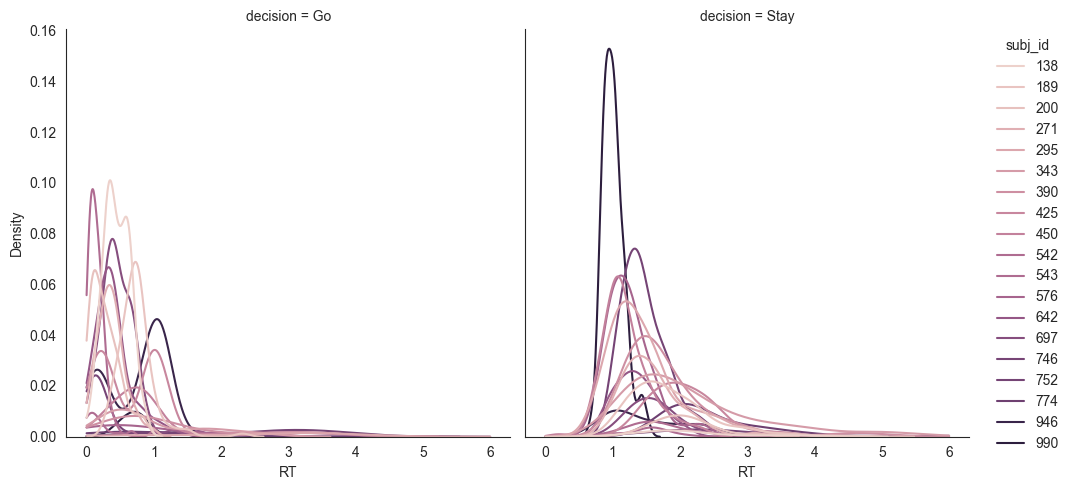

In [3]:
sns.displot(data=exp_measures, x="RT", hue="subj_id", col="decision", kind="kde", clip=(0, 6))

E:\source\cognitive-av\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


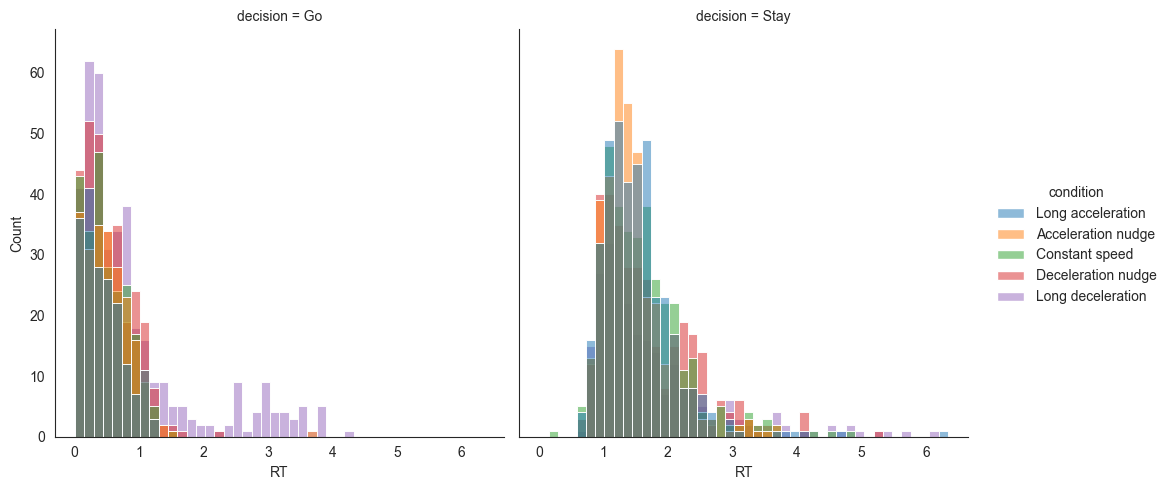

In [12]:
sns.displot(data=exp_measures, x="RT", hue="condition", col="decision", kind="hist")

E:\source\cognitive-av\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


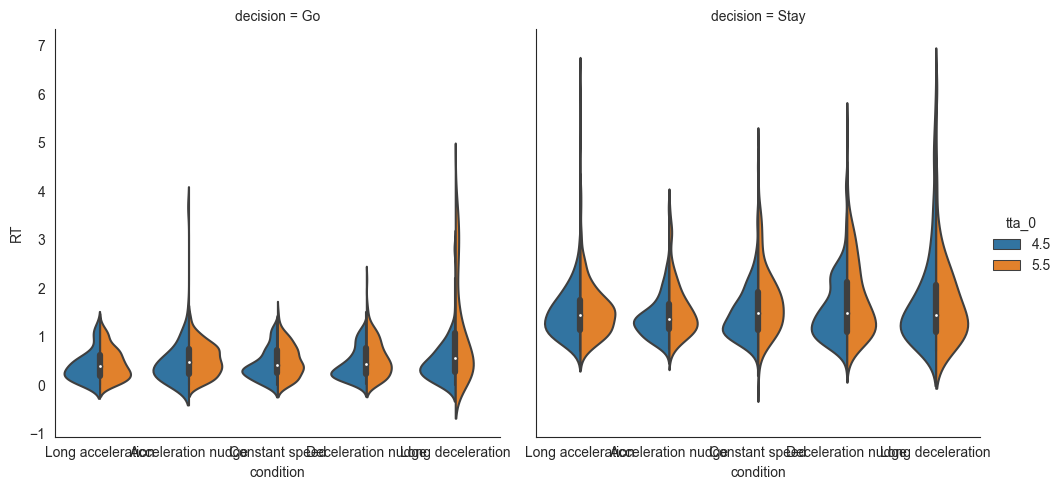

In [9]:
sns.catplot(data=exp_measures, x="condition", y="RT", col="decision", kind="violin", hue="tta_0", split=True)

### Mean differences

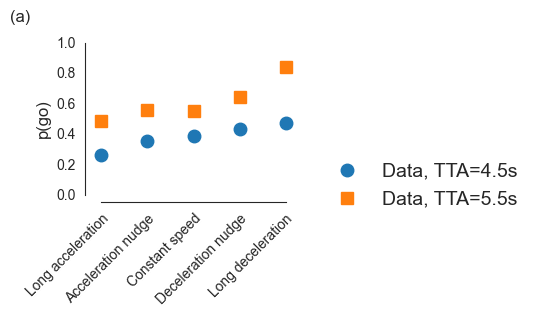

In [8]:
plot_var_by_condition(exp_measures, None, var="is_go_decision", model_label=None,
                      include_model=False, include_legend=True, subfigure_label="(a)")

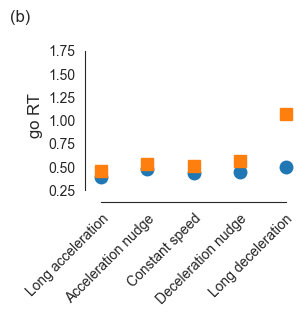

In [18]:
plot_var_by_condition(exp_measures, None, var="RT_go", model_label=None,
                      include_model=False, include_legend=False, subfigure_label="(b)")

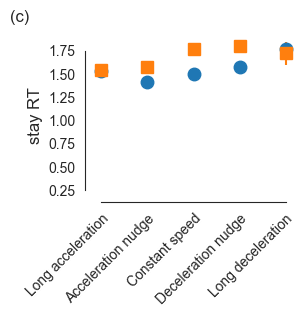

In [19]:
plot_var_by_condition(exp_measures, None, var="RT_stay", model_label=None,
                      include_model=False, include_legend=False, subfigure_label="(c)")

<Axes: xlabel='condition', ylabel='is_negative_rating'>

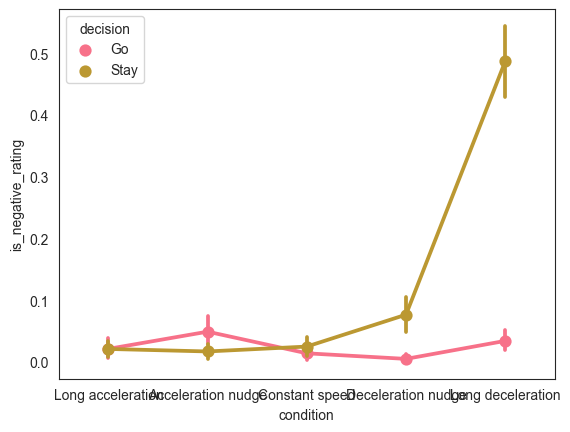

In [29]:
sns.pointplot(exp_measures, x="condition", y="is_negative_rating", hue="decision", palette=sns.color_palette("husl"))

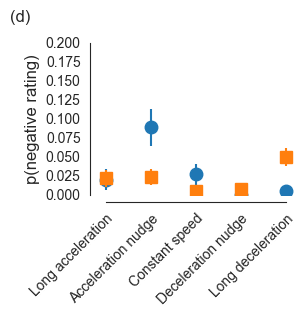

In [23]:
plot_var_by_condition(exp_measures[exp_measures.is_go_decision], None, var="is_negative_rating", model_label=None,
                      include_model=False, include_legend=False, subfigure_label="(d)")

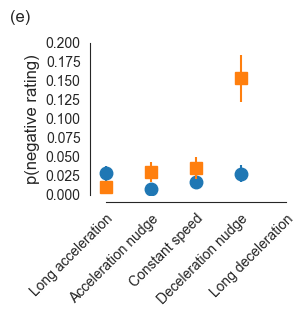

In [24]:
plot_var_by_condition(exp_measures[~exp_measures.is_go_decision], None, var="is_negative_rating", model_label=None,
                      include_model=False, include_legend=False, subfigure_label="(e)")

# Modeling (excluding NaN RTs) - Model 1 - cross-validation on Nudge conditions

In [84]:
model_label_cv="model_acceleration_dependent_cross_validation"
model_measures_cv = pd.read_csv("modeling/fit_results_excluded_nan_rt/%s/subj_all_sim_measures.csv" % model_label_cv)
model_measures_cv["a_values"] = model_measures_cv.a_values.apply(ast.literal_eval).apply(tuple)
model_measures_cv["condition"] = pd.Categorical(model_measures_cv["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

### Decision

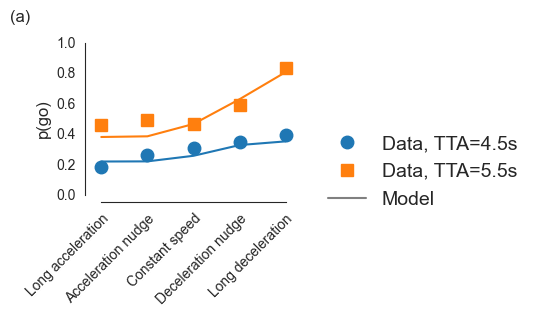

In [75]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="is_go_decision", model_label=model_label_cv, include_model=True, include_legend=True, subfigure_label="(a)")

### RT go

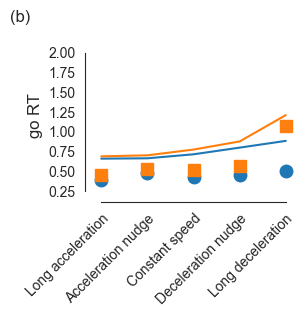

In [83]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="RT_go", model_label=model_label_cv, include_model=True, subfigure_label="(b)")

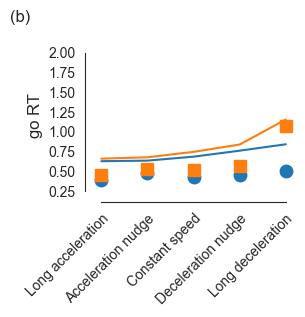

In [85]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="RT_go", model_label=model_label_cv, include_model=True, subfigure_label="(b)")

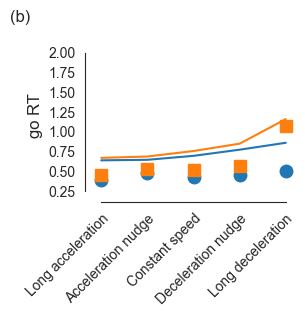

In [81]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="RT_go", model_label=model_label_cv, include_model=True, subfigure_label="(b)")

### RT stay

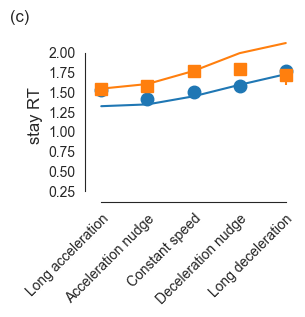

In [72]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="RT_stay", model_label=model_label_cv, include_model=True, subfigure_label="(c)")

# Model's full RT distributions

In [22]:
loss = "bic"
model_no = 2
path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
model_rt_pdf = pd.read_csv(os.path.join(path, "subj_all_sim_rt_pdf.csv"))
model_rt_cdf = pd.read_csv(os.path.join(path, "subj_all_sim_rt_cdf.csv"))
model_rt_pdf["a_values"] = model_rt_pdf.a_values.apply(ast.literal_eval).apply(tuple)
model_rt_pdf["condition"] = pd.Categorical(model_rt_pdf["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
model_rt_cdf["a_values"] = model_rt_cdf.a_values.apply(ast.literal_eval).apply(tuple)
model_rt_cdf["condition"] = pd.Categorical(model_rt_cdf["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

E:\source\cognitive-av\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Axes: xlabel='RT', ylabel='Density'>

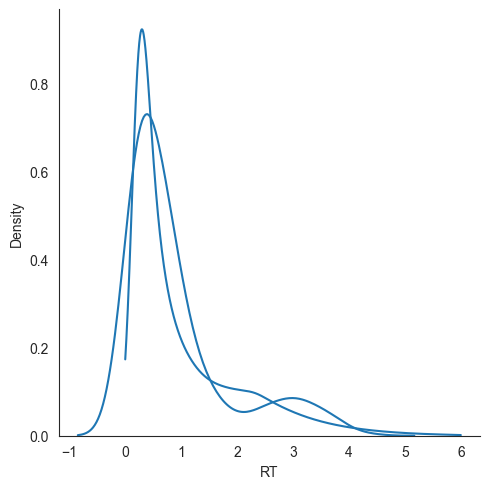

In [29]:
sns.displot(data=exp_measures[(exp_measures.decision=="Go") & (exp_measures.condition=="Long deceleration")], x="RT", kind="kde")
ax = plt.gca()
model_rt_pdf.rt_go_distr *= 0.8
sns.lineplot(data=model_rt_pdf[(model_rt_pdf.condition=="Long deceleration") & (model_rt_pdf.tta_0==5.5)], x="t", y="rt_go_distr", ax=ax)

E:\source\cognitive-av\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Axes: xlabel='RT', ylabel='Proportion'>

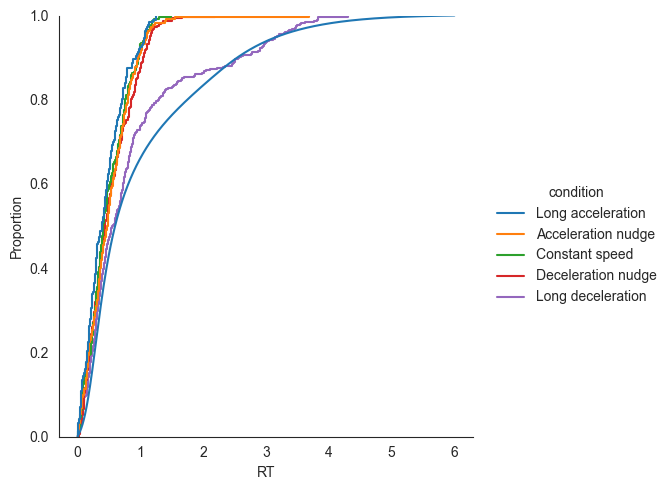

In [23]:
sns.displot(data=exp_measures[exp_measures.decision=="Go"], x="RT", hue="condition", kind="ecdf")
ax = plt.gca()
sns.lineplot(data=model_rt_cdf[(model_rt_cdf.condition=="Long deceleration") & (model_rt_cdf.tta_0==5.5)], x="t", y="rt_go_distr", ax=ax)

# Model predictions

In [17]:
model_label="model_acceleration_dependent_cross_validation"
model_measures = pd.read_csv("modeling/fit_results_excluded_nan_rt/%s/prediction_subj_all_sim_measures.csv" % model_label)
model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
model_measures["a_magnitude"] = model_measures.a_values.apply(lambda x: x[2])

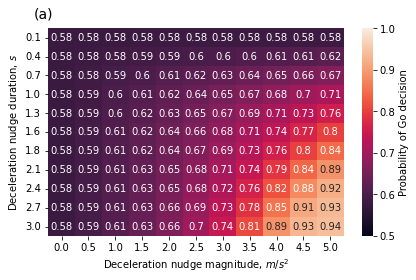

In [37]:
p_go = model_measures.pivot(index="a_duration", columns="a_magnitude", values="is_gap_accepted")
ax = sns.heatmap(p_go, vmin=0.5, vmax=1, annot=True, cbar_kws={"label": "Probability of Go decision"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.text(-0.55, -0.55, "(a)", fontsize=14)
plt.tight_layout()
plt.savefig("figures/predictions.png", bbox_inches="tight")

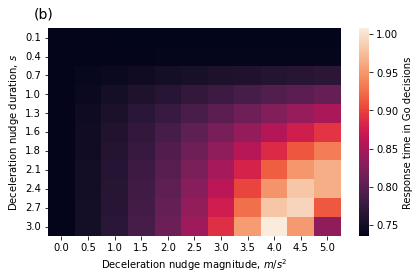

In [38]:
rt_go = model_measures.pivot(index="a_duration", columns="a_magnitude", values="RT_go")
ax = sns.heatmap(rt_go, cbar_kws={"label": "Response time in Go decisions"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.text(-0.55, -0.55, "(b)", fontsize=14)
plt.tight_layout()
plt.savefig("figures/predictions_RT_go.png", bbox_inches="tight")

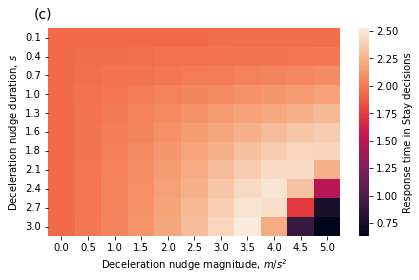

In [39]:
rt_stay = model_measures.pivot(index="a_duration", columns="a_magnitude", values="RT_stay")
ax = sns.heatmap(rt_stay, cbar_kws={"label": "Response time in Stay decisions"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.text(-0.55, -0.55, "(c)", fontsize=14)
plt.tight_layout()
plt.savefig("figures/predictions_RT_stay.png", bbox_inches="tight")

# Effect of $\beta_a$

## $\beta_a=0$

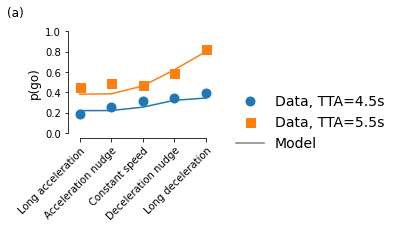

In [13]:
model_measures_cv = pd.read_csv("modeling/fit_results_excluded_nan_rt/%s/beta_a_0_subj_all_sim_measures.csv" % model_label_cv)
model_measures_cv["a_values"] = model_measures_cv.a_values.apply(ast.literal_eval).apply(tuple)
model_measures_cv["condition"] = pd.Categorical(model_measures_cv["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="is_go_decision", model_label=model_label_cv, include_model=True, include_legend=True, subfigure_label="(a)")

## $\beta_a=0.3$

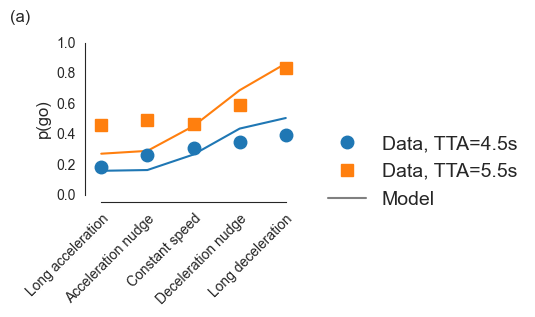

In [57]:
model_measures_cv = pd.read_csv("modeling/fit_results_excluded_nan_rt/%s/beta_a_0.3_subj_all_sim_measures.csv" % model_label_cv)
model_measures_cv["a_values"] = model_measures_cv.a_values.apply(ast.literal_eval).apply(tuple)
model_measures_cv["condition"] = pd.Categorical(model_measures_cv["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="is_go_decision", model_label=model_label_cv, include_model=True, include_legend=True, subfigure_label="(a)")

## $\beta_a=1$

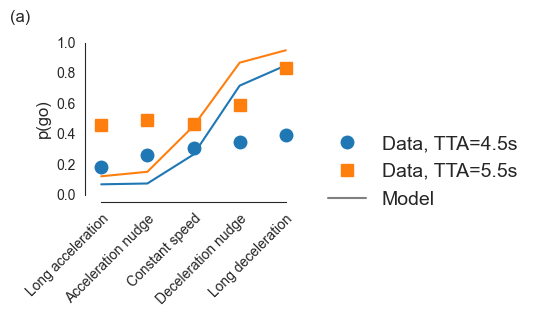

In [59]:
model_measures_cv = pd.read_csv("modeling/fit_results_excluded_nan_rt/%s/beta_a_1_subj_all_sim_measures.csv" % model_label_cv)
model_measures_cv["a_values"] = model_measures_cv.a_values.apply(ast.literal_eval).apply(tuple)
model_measures_cv["condition"] = pd.Categorical(model_measures_cv["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="is_go_decision", model_label=model_label_cv, include_model=True, include_legend=True, subfigure_label="(a)")

# Vincentized vs pooled data

In [43]:
exp_RTs = exp_measures[(exp_measures.RT < 6)]
exp_RTs[exp_RTs.is_go_decision].groupby("subj_id").count()

,session,route,intersection_no,idx_bot_visible,idx_response,idx_yield,idx_min_distance,min_distance,RT_gas,RT_yield,is_negative_rating,is_go_decision,tta_0,d_0,a_values,a_duration,decision,RT,condition
subj_id,,,,,,,,,,,,,,,,,,,
138,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163
189,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
200,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98
271,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
295,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
343,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44
390,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
425,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
450,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58


In [51]:
rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
# rt_quantiles = [0.5]
# First, get RT quantiles at these levels from the pooled data
quantiles = np.quantile(a=exp_RTs[exp_RTs.is_go_decision].RT, q=rt_quantiles)
# Second, get them per participant and average over all p's
vincentized_quantiles = (exp_RTs[exp_RTs.is_go_decision].groupby("subj_id").apply(lambda group: np.quantile(a=group.RT, q=rt_quantiles))).mean()
# Third, reconstruct the cdf/pdf's from the RT quantiles


In [52]:
quantiles

array([0.0966 , 0.28175, 0.4535 , 0.71755, 1.1126 ])

In [49]:
vincentized_quantiles

array([0.27286263, 0.48691158, 0.77130789, 0.98170474, 1.45543684])

In [59]:
def differentiate(t, x):
    # To be able to reasonably calculate derivatives at the end-points of the trajectories,
    # I append three extra points before and after the actual trajectory, so we get N+6
    # points instead of N
    x = np.append(x[0] * np.ones(3), np.append(x, x[-1] * np.ones(3)))

    # Time vector is also artificially extended by equally spaced points
    # Use median timestep to add dummy points to the time vector
    timestep = np.median(np.diff(t))
    t = np.append(t[0] - np.arange(1, 4) * timestep, np.append(t, t[-1] + np.arange(1, 4) * timestep))

    # smooth noise-robust differentiators, see:
    # http://www.holoborodko.com/pavel/numerical-methods/ \
    # numerical-derivative/smooth-low-noise-differentiators/#noiserobust_2
    v = (1 * (x[6:] - x[:-6]) / ((t[6:] - t[:-6]) / 6) +
         4 * (x[5:-1] - x[1:-5]) / ((t[5:-1] - t[1:-5]) / 4) +
         5 * (x[4:-2] - x[2:-4]) / ((t[4:-2] - t[2:-4]) / 2)) / 32

    return v

def plot_condition_vincentized_dist(ax, condition, condition_data, kind="cdf"):
    # colors = dict(zip([90,120,150], [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,3)]))
    # markers={90: "o", 120: "s", 150: "^"}
    #     q = [0.1, 0.3, 0.5, 0.7, 0.9]
    q = np.linspace(0.01, 0.99, 15)
    condition_quantiles = condition_data.groupby("subj_id").apply(lambda d: np.quantile(a=d.RT, q=q)).mean()

    rt_range = np.linspace(condition_quantiles.min(), condition_quantiles.max(), len(q))
    step = rt_range[1] - rt_range[0]
    rt_grid = np.concatenate([rt_range[:3] - 3 * step, rt_range, rt_range[-3:] + step * 3])

    vincentized_cdf = np.interp(rt_grid, condition_quantiles, q, left=0, right=1)

    if kind=="cdf":
        dist = vincentized_cdf
    elif kind=="pdf":
        dist = differentiate(rt_grid, vincentized_cdf)

    ax.plot(rt_grid, dist, label="Data", color="grey", ls="", ms=9, marker="o")
    ax.set_ylim([-0.05, 1.1])
    ax.set_yticks([0.0, 0.5, 1.0])

<AxesSubplot: xlabel='RT', ylabel='Proportion'>

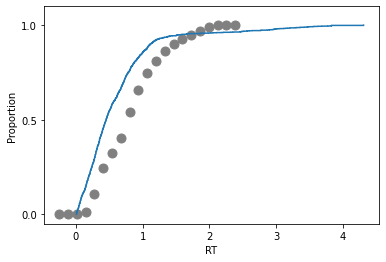

In [69]:
fig, ax = plt.subplots()
plot_condition_vincentized_dist(ax, condition=None, condition_data=exp_RTs[exp_RTs.is_go_decision])
sns.ecdfplot(exp_RTs[exp_RTs.is_go_decision].RT)

<AxesSubplot: xlabel='RT', ylabel='Density'>

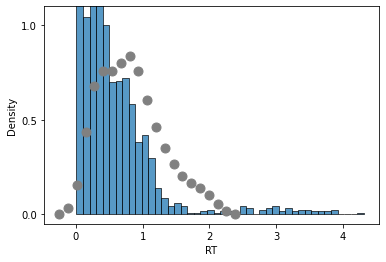

In [70]:
fig, ax = plt.subplots()
plot_condition_vincentized_dist(ax, condition=None, condition_data=exp_RTs[exp_RTs.is_go_decision], kind="pdf")
sns.histplot(exp_RTs[exp_RTs.is_go_decision].RT, stat="density")

# Mean values: pooled vs between-participant means

In [87]:
between_subj_mean = exp_RTs[exp_RTs.is_go_decision].groupby(["subj_id", "tta_0", "condition"]).mean()

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_27316\4069685537.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  between_subj_mean = exp_RTs[exp_RTs.is_go_decision].groupby(["subj_id", "tta_0", "condition"]).mean()


In [88]:
between_subj_mean.RT.groupby(["tta_0", "condition"]).mean()

tta_0  condition         
4.5    Long acceleration     0.401087
       Acceleration nudge    0.668401
       Constant speed        0.432536
       Deceleration nudge    0.422876
       Long deceleration     0.524226
5.5    Long acceleration     0.449137
       Acceleration nudge    0.562749
       Constant speed        0.546362
       Deceleration nudge    0.573357
       Long deceleration     1.017075
Name: RT, dtype: float64

In [85]:
exp_RTs[exp_RTs.is_go_decision].groupby(["tta_0", "condition"]).RT.mean()

tta_0  condition         
4.5    Long acceleration     0.394160
       Acceleration nudge    0.483165
       Constant speed        0.433556
       Deceleration nudge    0.448616
       Long deceleration     0.501627
5.5    Long acceleration     0.453072
       Acceleration nudge    0.534826
       Constant speed        0.516158
       Deceleration nudge    0.569424
       Long deceleration     1.075781
Name: RT, dtype: float64

# Compare to the model with bias

In [40]:
loss = "bic"
model_no = 2
path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
model_measures = pd.read_csv(os.path.join(path, "subj_all_sim_measures.csv"))
model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
model_measures["condition"] = pd.Categorical(model_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

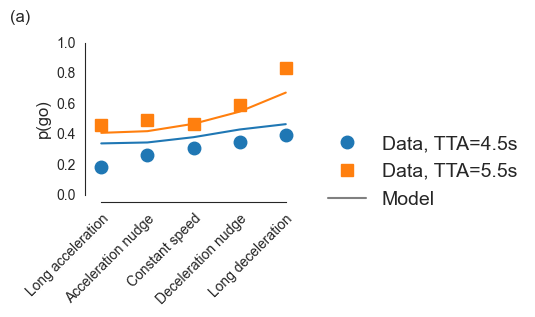

In [42]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="is_go_decision", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label="(a)")

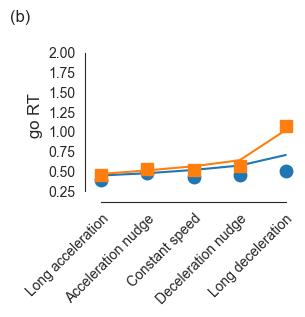

In [43]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="RT_go", model_label=str(model_no), include_model=True, subfigure_label="(b)")

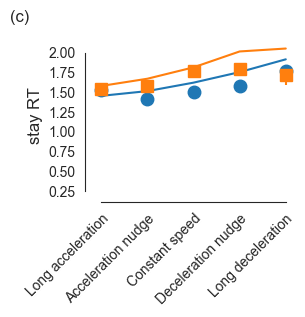

In [44]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="RT_stay", model_label=str(model_no), include_model=True, subfigure_label="(c)")

In [45]:
model_no = 4
path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
model_measures = pd.read_csv(os.path.join(path, "subj_all_sim_measures.csv"))
model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
model_measures["condition"] = pd.Categorical(model_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

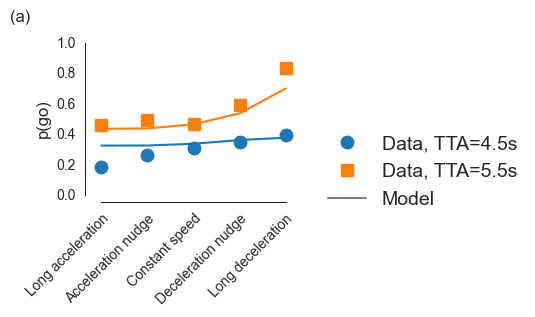

In [46]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="is_go_decision", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label="(a)")

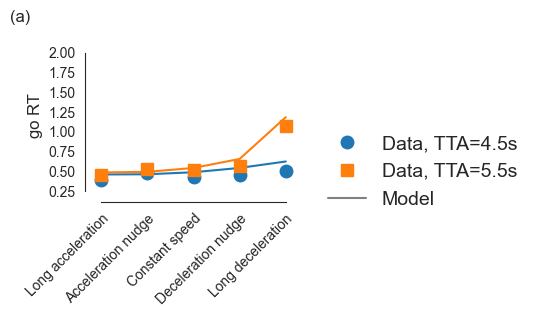

In [47]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="RT_go", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label="(a)")

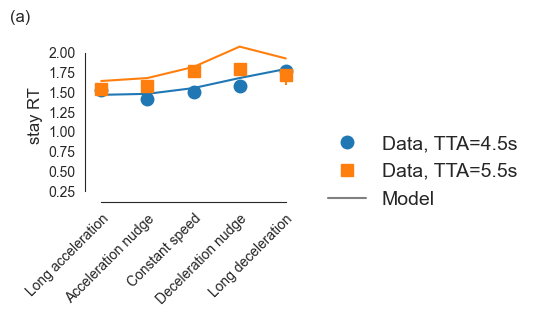

In [48]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="RT_stay", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label="(a)")

In [49]:
model_no = 5
path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
model_measures = pd.read_csv(os.path.join(path, "subj_all_sim_measures.csv"))
model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
model_measures["condition"] = pd.Categorical(model_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

# Compare fitting to vincentized data

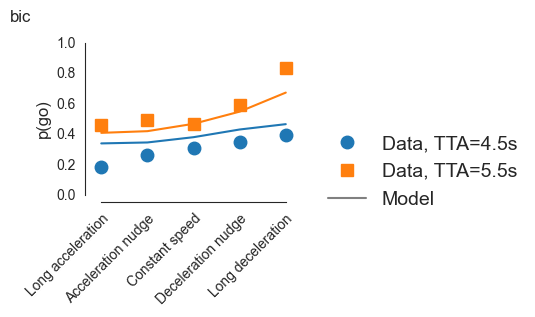

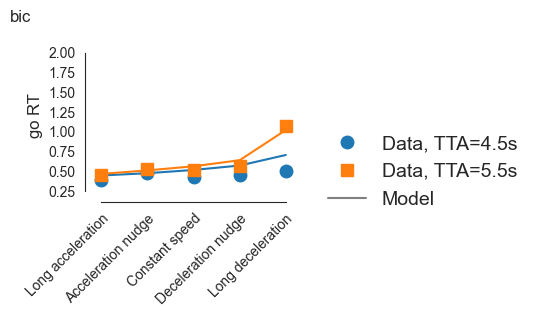

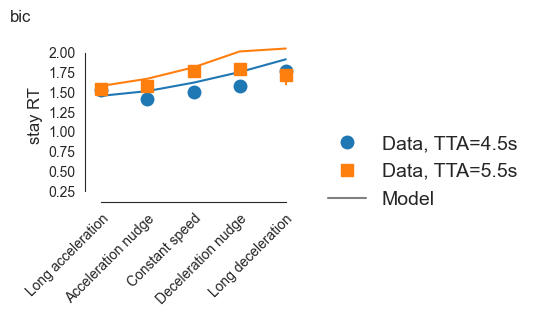

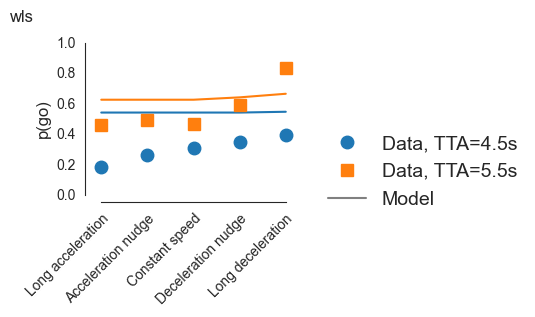

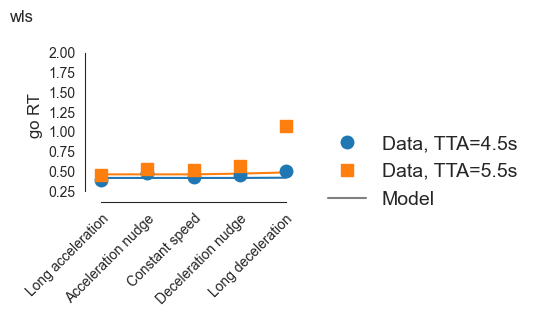

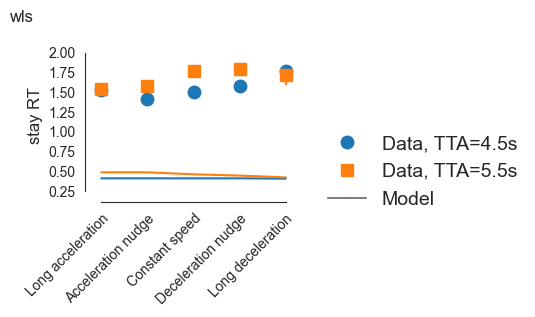

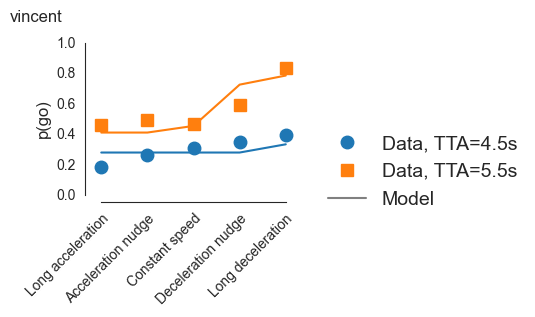

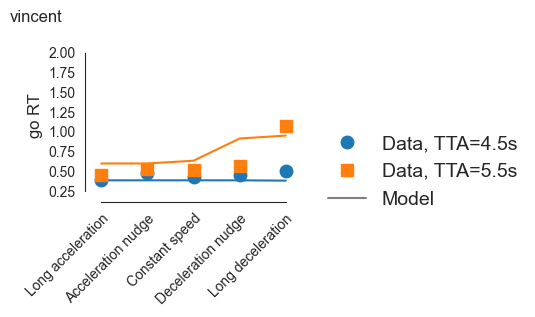

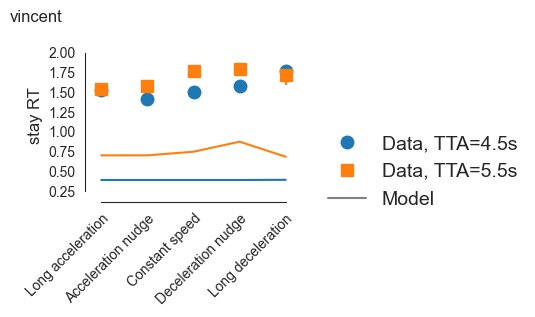

In [44]:
model_no = 2

for loss in ["bic", "wls", "vincent"]:
    path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
    model_measures = pd.read_csv(os.path.join(path, "subj_all_sim_measures.csv"))
    model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
    model_measures["condition"] = pd.Categorical(model_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
    plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="is_go_decision", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label=loss)
    plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="RT_go", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label=loss)
    plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="RT_stay", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label=loss)

# Checking TTA and boundaries

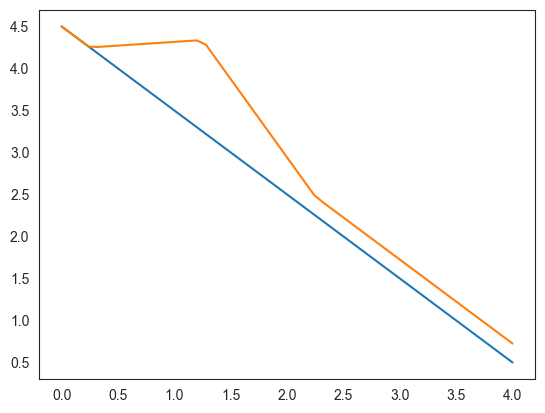

In [32]:
T_dur = 4
t = np.linspace(0, T_dur, 51)
d_0 = 80
tta_0 = 4.5
plt.plot(t, tta_0-t)

a_values = [0, -4, 4, 0]
a_duration = 1

breakpoints = np.array([0., 0.25, (0.25+a_duration), min(0.25 + a_duration*2, T_dur)] + [T_dur])
v_0 = d_0 / tta_0
a_values = np.concatenate([a_values, [0.]])
v_values = np.concatenate([[v_0], v_0 + np.cumsum(np.diff(breakpoints) * a_values[:-1])])
d_values = np.concatenate([[d_0], d_0 - np.cumsum(np.diff(breakpoints) * (v_values[1:] + v_values[:-1]) / 2)])

tta_values = d_values / v_values

f_tta = interpolate.interp1d(breakpoints, tta_values, kind=1)
plt.plot(t, f_tta(t))

In [38]:
path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
parameters = pd.read_csv(os.path.join(path, "subj_all_parameters_fitted.csv"))

In [39]:
parameters

,subj_id,loss,alpha,beta_d,beta_a,theta,b_0,k,tta_crit,x0,ndt_location,ndt_scale
0,all,0.15854,0.046152,0.050419,6.005716,0.906694,3.066967,1.99619,5.824033,0.094317,0.002477,0.458421


(0.0, 1.0541289803343723)

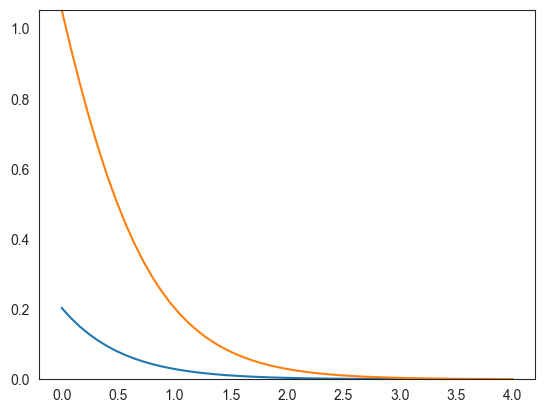

In [40]:
T_dur = 4
t = np.linspace(0, T_dur, 51)
b_45 = parameters["b_0"].values / (1 + np.exp(-parameters["k"].values * ((4.5-t) - parameters["tta_crit"].values)))
plt.plot(t, b_45)
b_55 = parameters["b_0"].values / (1 + np.exp(-parameters["k"].values * ((5.5-t) - parameters["tta_crit"].values)))
plt.plot(t, b_55)
ax = plt.gca()
ax.set_ylim((0, b_55[0]))

# New script for simulating fitted models

In [35]:
from pathlib import Path
from models import *
from pyddm import Model, Fitted, NoiseConstant, ICPointRatio, FitResult
txt = Path("modeling/logs/bic_model_4_2023-08-12-22-20-48.txt").read_text()
model = eval(txt)

SyntaxError: invalid syntax (<string>, line 2)

In [105]:
print(model)

Model(name='Model 2',
      drift=DriftAccelerationDependent(alpha=Fitted(0.32675763581839723, minval=0.0, maxval=5.0), beta_d=Fitted(0.0019307372728687433, minval=0.0, maxval=1.0), beta_a=Fitted(0.1139301806703017, minval=0.0, maxval=10.0), theta=Fitted(7.530086121849835, minval=0, maxval=20)),
      noise=NoiseConstant(noise=1),
      bound=BoundCollapsingTta(b_0=Fitted(2.7357375595070104, minval=0.5, maxval=5.0), k=Fitted(0.01969127453675712, minval=0.001, maxval=2.0), tta_crit=Fitted(5.7404525191975315, minval=2.0, maxval=10.0)),
      IC=ICPointRatio(x0=Fitted(0.625239057520607, minval=-1.0, maxval=1.0)),
      overlay=OverlayNonDecisionGaussian(ndt_location=Fitted(0.11644823936808946, minval=0, maxval=2.0), ndt_scale=Fitted(0.15556594407364197, minval=0.001, maxval=0.5)),
      dx=0.005,
      dt=0.005,
      T_dur=6.0,
  fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=4910.928327649488, nparams=10, samplesize=1799, mess=''),
  choice

In [1]:
conditions = [{"tta_0": tta_0, "d_0": d_0, "a_values": a_values, "a_duration": a_duration}
              for tta_0 in [4.5, 5.5]
              for d_0 in [80]
              for a_values in [(0., 0., 0., 0.),
                               (0., 4, 4, 0.),
                               (0., 4, -4, 0.),
                               (0., -4, 4, 0.),
                               (0., -4, -4, 0.)]
              for a_duration in [1.0]]

solutions = [model.solve(condition) for condition in conditions]

NameError: name 'model' is not defined

In [100]:
prob = [sol.prob(choice="Go") for sol in solutions]

In [9]:
ds = [condition["d_0"] for condition in conditions]

In [30]:
conditions = [{"tta_0": tta_0, "d_0": d_0, "a_values": a_values}
              for tta_0 in [4.5, 5.5]
              for d_0 in [80]
              for a_values in [(0., 0., 0., 0.),
                               (0., 4, 4, 0.),
                               (0., 4, -4, 0.),
                               (0., -4, 4, 0.),
                               (0., -4, -4, 0.)]]

In [31]:
condition = conditions[0]

In [34]:
eval(str(condition))

{'tta_0': 4.5, 'd_0': 80, 'a_values': (0.0, 0.0, 0.0, 0.0)}